In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
c:\Users\Usuario\anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Usuario\anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Usuario\anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Usuario\anaconda3\envs\test\lib\sit

# Keras clasificador de imagenes

In [2]:
# 1 Configuración de parámetros

width_shape = 224
height_shape = 224
num_classes = 10
epochs = 2 # Número de iteraciones es 50
batch_size = 32 

In [3]:
# Importación de datos

train_data_dir = 'C:/Users/Usuario/Archivos en Jupyter/Tensorflow/Bird_Classification--master/dataset/train'

validation_data_dir = 'C:/Users/Usuario/Archivos en Jupyter/Tensorflow/Bird_Classification--master/dataset/valid'


In [4]:
# Generador de imagenes
# crea la estructura de datos para el entrenamiento
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input) # preprocessing_function para normalizar los datos

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input) #preprocessing_function para normalizar los datos


In [5]:
# creamos los datos de entrenamiento
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 1490 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
#Creación de modelo 
nb_train_samples = 1490
nb_validation_samples = 50

model = Sequential()

inputShape = (height_shape, width_shape, 3) # dimensiones de la imagen de entrada
# luego se definen operaciones, como max pooling, convoluciones
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(Conv2D(32,(3,3)))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D())

model.add(Flatten()) #aplanado de las salidas de las capas anteriores
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 104, 104, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 64)      

In [7]:

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model_history = model.fit_generator(  #hace data aumentation a medida que se entrene
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)


Epoch 1/2
46/46 [==============================] - 487s 11s/step - loss: 101.0535 - accuracy: 0.1571 - val_loss: 5.4738 - val_accuracy: 0.1250
Epoch 2/2
46/46 [==============================] - 521s 11s/step - loss: 2.7399 - accuracy: 0.1488 - val_loss: 2.2124 - val_accuracy: 0.1111


In [8]:
# Entrenamiento de modelo VGG16

nb_train_samples = 1490
nb_validation_samples = 50

image_input = Input(shape=(width_shape, height_shape, 3)) # definimos la entrada

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') #conserva los pesos

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
 # transferimos los pesos de la red VGG16 a nuestra red personalizada
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

model_history = custom_vgg_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Guardar un modelo

In [9]:
custom_vgg_model.save("model_VGG16.h5")

# Graficamos un modelo

In [10]:
# Gráficas de entrenamiento y validación (accuracy - loss)
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

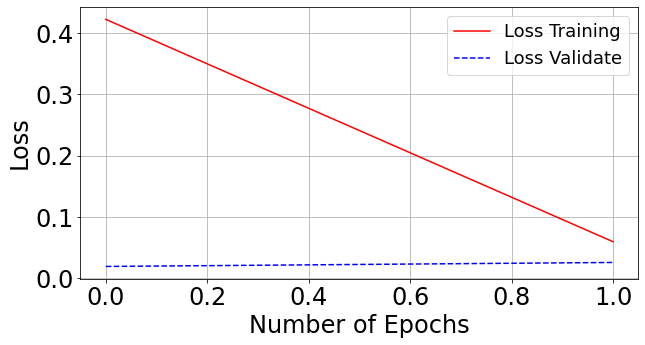

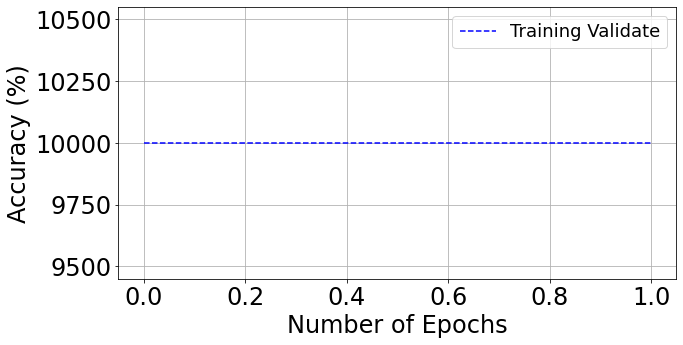

In [15]:
# Muestra las graficas

plotTraining (model_history, epochs, "loss")
plotTraining (model_history, epochs, "acuracy")
plotTraining (model_history, epochs, "val_loss")
plotTraining (model_history, epochs, "val_accuracy")

# Predicción usando el modelo entrenado

AMERICAN BITTERN


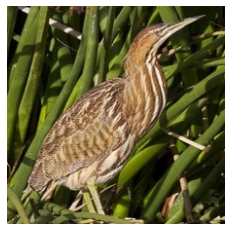

In [12]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

modelt = load_model("model_VGG16.h5")
#modelt = custom_vgg_model

imaget_path = "C:/Users/Usuario/Archivos en Jupyter/Tensorflow/Bird_Classification--master/dataset/test/AMERICAN BITTERN/5.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 50 images belonging to 10 classes.
              precision    recall  f1-score   support

           0     0.6667    0.8000    0.7273         5
           1     0.7143    1.0000    0.8333         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    0.6000    0.7500         5
           4     1.0000    1.0000    1.0000         5
           5     0.8333    1.0000    0.9091         5
           6     1.0000    0.6000    0.7500         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     0.8000    0.8000    0.8000         5

    accuracy                         0.8800        50
   macro avg     0.9014    0.8800    0.8770        50
weighted avg     0.9014    0.8800    0.8770        50



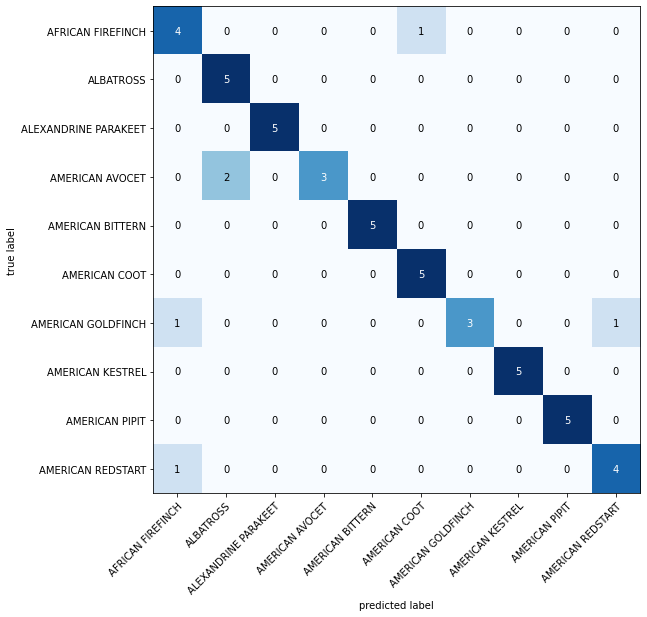

In [52]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
%matplotlib inline


names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']


test_data_dir = 'C:/Users/Usuario/Archivos en Jupyter/Tensorflow/Bird_Classification--master/dataset/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_VGG16.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))